## Dependencies

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cleaned_data_dir = "./data/cleaned/"

In [3]:
cd ..

/home/jake/Projects/mila/6758/hockey


# Setup Data

In [4]:
team_files = os.listdir(cleaned_data_dir)

plays = pd.concat([pd.read_csv(os.path.join(cleaned_data_dir, team_file)) for team_file in team_files])
plays = plays.drop("Unnamed: 0", axis=1)
plays.shape

(385076, 29)

In [5]:
# plays_full = plays.copy()
# plays = plays.sample(2000)  # TODO delete

In [6]:
plays['season'] = plays['game_id'].apply(lambda gid: int(str(gid)[:4]))
plays['subseason'] = plays['game_id'].apply(lambda gid: int(str(gid)[4:6])).replace({2: 'regular', 3: 'playoffs'})

In [7]:
plays = plays.rename({'shooter_team_name': 'team'}, axis=1)

In [8]:
plays = plays[plays['coordinate_x'] >= 25]  # only consider shots in offensive zone

## Calculate Game Length

In [9]:
def game_length(events):
    """ Calculate game length from events """
    last_event = events.sort_values('event_index', ascending=False).iloc[0]
    time = last_event['time']
    last_period = last_event['period']

    time_in_minutes = int(time[:2]) + int(time[3:])/60
    game_length = 60 if last_period <= 3 else (last_period-1)*20 + time_in_minutes
    return game_length

In [10]:
team_game_lengths = plays.groupby(['team','season','subseason','game_id']).apply(game_length)

In [11]:
team_game_lengths.describe(percentiles=[.9,.95,.99])

count    12300.000000
mean        61.819935
std          5.516194
min         60.000000
50%         60.000000
90%         63.618333
95%         80.000000
99%         80.000000
max        150.450000
dtype: float64

In [12]:
team_minutes = team_game_lengths.groupby(['team','season','subseason']).sum()
team_minutes.name = 'Minutes'

## Shots per Hour

In [60]:
team_shots = plays.groupby(['team','season','subseason','coordinate_x','coordinate_y']).size()
team_shots.name = 'Shots'
team_shots = pd.DataFrame(team_shots)
team_shots.shape

(262855, 1)

In [82]:
team_shots_per_hour = team_shots.join(team_minutes)
team_shots_per_hour['shots_per_hour'] = team_shots_per_hour['Shots'] / \
                                        (team_shots_per_hour['Minutes'] / 60)
team_shots_per_hour.shape

(1791636, 3)

In [83]:
league_shots = team_shots_per_hour.groupby(team_shots_per_hour.index.names[1:])[['Shots']].sum()
league_minutes = team_minutes.groupby(team_minutes.index.names[1:]).sum()

league_shots_per_hour = league_shots.join(league_minutes)

league_shots_per_hour['league_shots_per_hour'] = league_shots_per_hour['Shots'] / \
                                                 (league_shots_per_hour['Minutes'] / 60)
league_shots_per_hour = league_shots_per_hour[['league_shots_per_hour']]  # drop other columns

league_shots_per_hour.shape

(58170, 1)

In [84]:
teams = plays[['team','season']].drop_duplicates().sort_values(['team','season'])
subseason = pd.DataFrame({'subseason': ['regular', 'playoffs']})
coordinates = league_shots_per_hour.reset_index()[['coordinate_x', 'coordinate_y']].drop_duplicates()

team_shots_spine = teams.merge(subseason, how='cross')\
                        .merge(coordinates, how='cross')

assert team_shots_spine.shape[0] == len(teams) * len(subseason) * len(coordinates)

team_shots_spine = team_shots_spine.set_index(['team','season','subseason','coordinate_x','coordinate_y'])
team_shots_per_hour = team_shots_spine.join(team_shots_per_hour, how='left').fillna(0)
team_shots_per_hour.shape  # (1791636, 1)

(1791636, 3)

In [85]:
team_shots_per_hour = \
    team_shots_per_hour.join(
        league_shots_per_hour, on=league_shots_per_hour.index.names
    )

In [32]:
# TODO: not correct
# team_shots_per_hour['x_bin'] = team_shots_per_hour.index
# def round_to_nearest_x(arr,x,offset):
#      res = x * ((arr-offset) // x) + offset
#      res = res + (x-1)/2 # if x%2 == 1 else res + x/2  # make coordinate in middle
#      return res

# team_shots_per_hour['x_bin'] = round_to_nearest_x(team_shots_per_hour.index.get_level_values('coordinate_x'), 1, 0)
# team_shots_per_hour['x_bin'].replace({101: 100}, inplace = True)  # smooth edge to original value
# # team_shots_per_hour.loc[team_shots_per_hour['x_bin'] == -43, 'x_bin'] = -42  
# team_shots_per_hour['y_bin'] = round_to_nearest_x(team_shots_per_hour.index.get_level_values('coordinate_y'), 1, 0)
# team_shots_per_hour['y_bin'].replace({-43: -42}, inplace = True)  # smooth edge to original value

In [34]:
# team_shots_per_hour_binned = \
#     team_shots_per_hour.reset_index().groupby(['team', 'season', 'subseason', 'x_bin','y_bin'])\
#         [['shots_per_hour', 'league_shots_per_hour']].sum()

In [88]:
team_shots_per_hour_binned = team_shots_per_hour

In [89]:
team_shots_per_hour_binned['relative_shots_per_hour'] = \
    team_shots_per_hour_binned['shots_per_hour'] - team_shots_per_hour_binned['league_shots_per_hour']

In [ ]:
os.makedirs("./data/advanced_viz/", exist_ok=True)

In [91]:
team_shots_per_hour_binned.to_csv("./data/advanced_viz/shots_per_hour.csv")

## Checks

In [92]:
ducks = team_shots_per_hour_binned.loc[('Anaheim Ducks', 2016, 'regular')]
ducks

/tmp/ipykernel_760089/9651229.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  ducks = team_shots_per_hour_binned.loc[('Anaheim Ducks', 2016, 'regular')]


Shots  Minutes  shots_per_hour  \
coordinate_x coordinate_y                                   
25.0         -40.0           0.0   5052.3        0.000000   
             -38.0           1.0   5052.3        0.011876   
             -37.0           0.0   5052.3        0.000000   
             -36.0           0.0   5052.3        0.000000   
             -35.0           0.0   5052.3        0.000000   
...                          ...      ...             ...   
99.0         -13.0           0.0   5052.3        0.000000   
             -10.0           0.0   5052.3        0.000000   
              10.0           0.0   5052.3        0.000000   
              11.0           0.0   5052.3        0.000000   
              13.0           0.0   5052.3        0.000000   

                           league_shots_per_hour  relative_shots_per_hour  
coordinate_x coordinate_y                                                  
25.0         -40.0                      0.000000                 0.000000  
             -38.0                      0.000394                 0.011481  
             -37.0                      0.000789                -0.000789  
             -36.0                      0.000394                -0.000394  
             -35.0                      0.000394                -0.000394  
...                                          ...                      ...  
99.0         -13.0                      0.000000                 0.000000  
             -10.0                      0.000000                 0.000000  
              10.0                      0.000000                 0.000000  
              11.0                      0.000000                 0.000000  
              13.0                      0.000000                 0.000000  

[5817 rows x 5 columns]

In [93]:
sns.set(rc={'figure.figsize':(10,6)})

<AxesSubplot:xlabel='coordinate_x', ylabel='coordinate_y'>

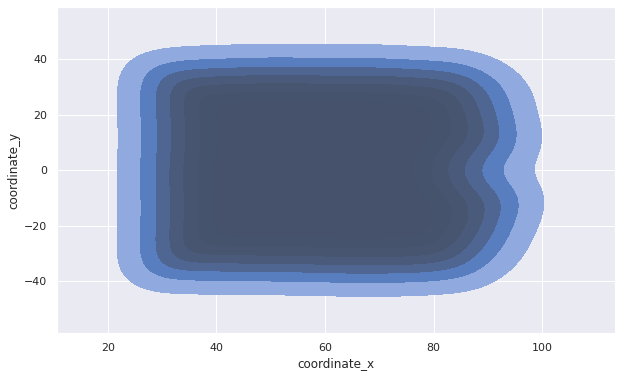

In [94]:
sns.kdeplot(
    data=ducks[['shots_per_hour']].reset_index(), x="coordinate_x", y="coordinate_y", fill=True,
)

<AxesSubplot:xlabel='coordinate_x', ylabel='coordinate_y'>

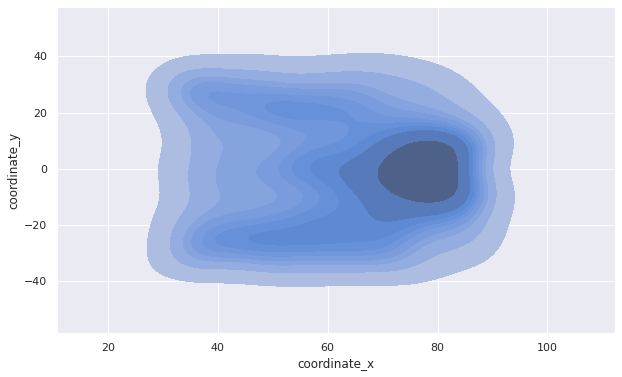

In [45]:
sns.kdeplot(
    data=ducks[['league_shots_per_hour']].reset_index(), x="coordinate_x", y="coordinate_y", fill=True,
)

In [96]:
team_shots_per_hour_binned[['shots_per_hour', 'league_shots_per_hour', 'relative_shots_per_hour']].describe()

,shots_per_hour,league_shots_per_hour,relative_shots_per_hour
count,1.791636e+06,1.791636e+06,1.791636e+06
mean,3.745679e-03,4.912195e-03,-1.166516e-03
std,1.482933e-02,6.805278e-03,1.418330e-02
min,0.000000e+00,0.000000e+00,-1.189046e-01
25%,0.000000e+00,0.000000e+00,-5.552531e-03
50%,0.000000e+00,3.450613e-03,-7.668029e-04
75%,0.000000e+00,6.109496e-03,0.000000e+00
max,6.153496e-01,1.189046e-01,5.587283e-01


<AxesSubplot:xlabel='coordinate_x', ylabel='coordinate_y'>

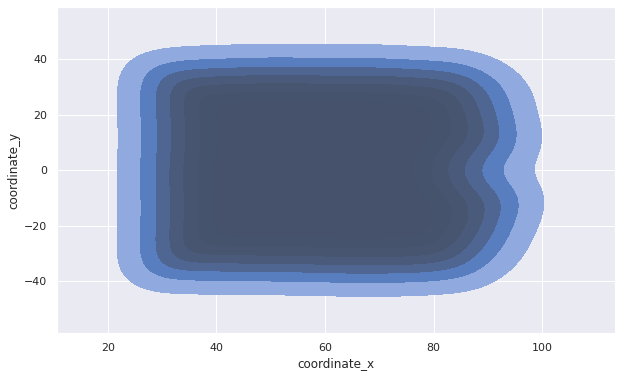

In [95]:
sns.kdeplot(
    data=ducks[['relative_shots_per_hour']].reset_index(), x="coordinate_x", y="coordinate_y", fill=True,
)